# MicroInception v1

Curso: [Introducción al Aprendizaje Profundo](http://turing.iimas.unam.mx/~ricardoml/course/iap/). Profesores: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/) Montalvo Lezama.

---
---

En este ejemplo realizaremos implementación sencilla del bloque Inception v1. Emplearemos una versión reducida de Recipes5k, para resolver una tarea de clasificación binara que consiste en aprender para predecir si la comida en la imagen es saludable o no.

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/recipes5k.jpg"/>

## 1. Preparación

In [ ]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torchinfo

### 1.1. Bibliotecas

In [ ]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
import os

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvutils
# imágenes
from skimage import io
from skimage.transform import resize
# redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm.auto import trange
# imágenes
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

### 1.2. Auxiliares

In [ ]:
# directorio de datos
URL = 'https://cloud.xibalba.com.mx/s/e4dZiWt2bZCGWQ9/download'
base_dir = '../datos/recipes'
filename = 'recipes2k.tar.gz'
data_dir = '../datos/recipes/recipes2k'
filepath = os.path.join(base_dir, filename)

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8
# tamaño de la imagen
IMG_SIZE = 64


def crop_center(img, cropx, cropy):
    y, x = img.shape[:2]
    startx = x // 2 - cropx // 2
    starty = y // 2 - cropy // 2    
    return img[starty:starty+cropy, startx:startx+cropx]


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def numpy_to_torch(x):
    x = transforms.functional.to_tensor(x)
    x = x.type(torch.float32)
    return x


# reproducibilidad
set_seed()

## 2. Datos

### 2.1. Tuberias de datos con PyTorch

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/mnist_pipeline.png"/>

### 2.2. Descarga de Recipes2k

In [ ]:
! mkdir -p {base_dir}
! wget -nc {URL} -O {filepath}
! tar -zxf {filepath} -C {base_dir}

--2021-05-12 08:03:10--  https://cloud.xibalba.com.mx/s/e4dZiWt2bZCGWQ9/download
Resolving cloud.xibalba.com.mx (cloud.xibalba.com.mx)... 187.189.27.18
Connecting to cloud.xibalba.com.mx (cloud.xibalba.com.mx)|187.189.27.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93675898 (89M) [application/x-gzip]
Saving to: ‘../datos/recipes/recipes2k.tar.gz’

../datos/recipes/re 100%[===================>]  89.34M  8.39MB/s    in 10s     

2021-05-12 08:03:21 (8.83 MB/s) - ‘../datos/recipes/recipes2k.tar.gz’ saved [93675898/93675898]



### 2.3. Conjunto de datos

In [ ]:
df = pd.read_csv(os.path.join(data_dir, 'trn.csv'), index_col='item')
df.head()

,healthy,junk,dessert,appetizer,mains,soups,carbs,protein,fats,meat
item,,,,,,,,,,
apple_pie,0,0,1,0,0,0,1,0,1,0
baby_back_ribs,0,0,0,0,1,0,0,1,1,1
beef_tacos,0,0,0,0,1,0,1,1,1,1
beet_salad,1,0,0,0,1,0,0,1,0,0
bread_pudding,0,0,1,0,0,0,1,0,1,0


In [ ]:
! ls {data_dir}/trn/beet_salad | head -5

0_maple_roasted_beet_and_goat_cheese_salad.jpg
10_balsamic_beet_salad_with_arugula_and_goat_cheese.jpg
11_roasted_beet_and_goat_cheese_salad.jpg
12_cathys_bodacious_beet_salad.jpg
13_red_beet_salad.jpg


In [ ]:
class RecipesDS:

    def __init__(self, root, tsfm):
        
        # guardamos la tranformación para las imágenes
        self.tsfm = tsfm
        
        # leemos el dataframe y filtramos columna healthy
        df = pd.read_csv(os.path.join(root, 'trn.csv'), index_col='item')
        df = df['healthy']
        
        # direcorios superiores
        base_dir = os.path.join(root, 'trn')
        classes = sorted(os.listdir(base_dir))
        
        # lista con las rutas a las imágenes
        self.paths = []
        # lista con las etiquetas de las imágenes
        self.labels = []
        
        # por cada clase
        for clazz in classes:
            # directorio de la clase
            class_dir = os.path.join(base_dir, clazz)
            # nombres de los archivos en el directorio de la clase
            names = sorted(os.listdir(class_dir))
            # guardamos los rutas y las etiquetas
            for name in names:
                self.paths.append(os.path.join(class_dir, name))
                self.labels.append(df.loc[clazz])

    def __getitem__(self, i):
        # obtenemos la ruta de la imagen
        path = self.paths[i]
        # cargamos la imagen
        x = Image.open(path)
        # aplicamos transformación
        x = self.tsfm(x)
        # leeamos la etiqueta
        y = np.array(self.labels[i], np.float32).reshape(1)
        # regresamos el ejemplo
        return x, y

    def __len__(self):
        # número de ejemplos en el conjunto
        return len(self.paths)

### 2.4. Exploración

x shape=torch.Size([32, 64, 64, 3]) dtype=torch.uint8
y shape=torch.Size([32, 1]) dtype=torch.float32


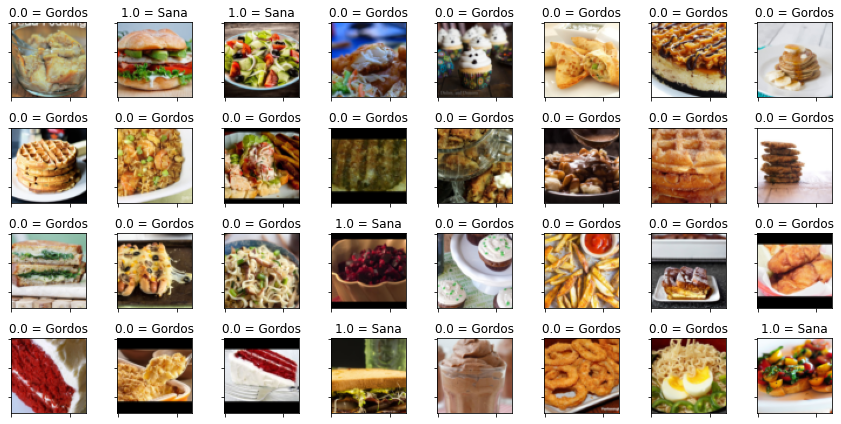

In [ ]:
tsfm = transforms.Compose([
    # recortamos al centro a 240x240
    transforms.CenterCrop(240),
    # redimensionamos a 64x64
    transforms.Resize(IMG_SIZE),
    # convertimos a ndarray
    np.array
])

ds = RecipesDS(data_dir, tsfm)

dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{l.item()} = Sana' if l else f'{l.item()} = Gordos' for l in y]
display_grid(x, titles, ROWS, COLS)

### 2.3 Cargador de datos

x shape=torch.Size([32, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([32, 1]) dtype=torch.float32


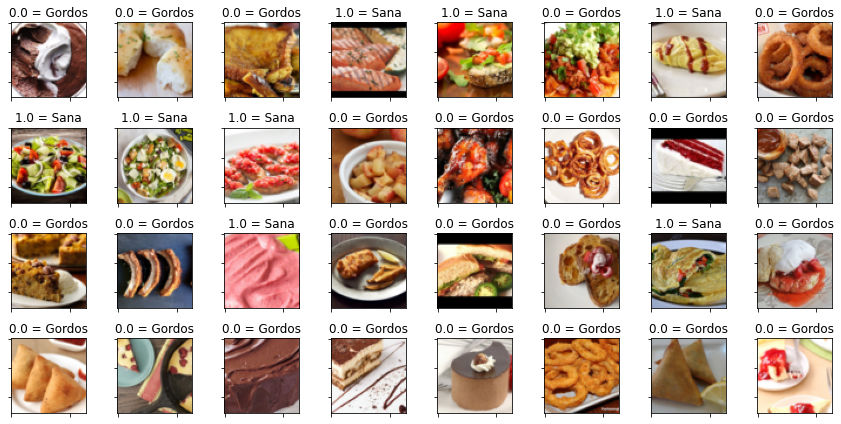

In [ ]:
#Datos de entrenamiento
tsfm = transforms.Compose([
    # recortamos al centro a 240x240
    transforms.CenterCrop(240),
    # redimensionamos a 64x64
    transforms.Resize(IMG_SIZE),
    # de numpy.ndarray    (H x W x C) en rango [0, 255]
    # a torch.FloatTensor (C x H x W) en rango [0, 1]
    transforms.ToTensor(),
])

trn_ds = RecipesDS(data_dir, tsfm)

trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
titles = [f'{l.item()} = Sana' if l else f'{l.item()} = Gordos' for l in y]
display_batch(x, titles, ROWS, COLS)

## 3. Arquitectura

<!-- ![arch](https://raw.githubusercontent.com/richardtml/riiaa-20-aa/master/media/fc.jpg) -->

### 3.1. Definición de bloque Inception

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/inception_block_2branches.svg" width="700"/>

In [ ]:
class InceptionBlock(nn.Module):

    def __init__(self, in_channels, 
                 out_channels1, out_channels3):
        super(InceptionBlock, self).__init__()
        out_channels31,out_channels32=out_channels3

        self.b1=nn.Conv2d(in_channels=in_channels, out_channels=out_channels1, 
                      kernel_size=1, padding=0)
        
        self.b2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels31, 
                      kernel_size=1,padding=0),
            nn.BatchNorm2d(out_channels31),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels31, out_channels=out_channels32, 
                      kernel_size=5, padding=2),
            nn.BatchNorm2d(out_channels32),
            nn.ReLU()
        )  
        
    # metodo para inferencia
    def forward(self, x):
        x1 = self.b1(x)
        x2 = self.b2(x)
        x=torch.cat((x1,x2), 1)
        x=F.relu(x)
        return x

Creemos un modelo:

In [ ]:
block = InceptionBlock(in_channels=3, 
                       out_channels1=4,
                       out_channels3=(4, 4))
block

InceptionBlock(
  (b1): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
  (b2): Sequential(
    (0): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
)

Probemos con datos sintéticos:

In [ ]:
x = torch.zeros(1, 3, 64, 64)
y = block(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 64, 64]) => torch.Size([1, 8, 64, 64])


Inspeccionemos:

In [ ]:
summary(block, (1, 3, 64, 64), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
InceptionBlock                           --                        --
├─Conv2d: 1-1                            [1, 4, 64, 64]            16
├─Sequential: 1-2                        [1, 4, 64, 64]            --
│    └─Conv2d: 2-1                       [1, 4, 64, 64]            16
│    └─BatchNorm2d: 2-2                  [1, 4, 64, 64]            8
│    └─ReLU: 2-3                         [1, 4, 64, 64]            --
│    └─Conv2d: 2-4                       [1, 4, 64, 64]            404
│    └─BatchNorm2d: 2-5                  [1, 4, 64, 64]            8
│    └─ReLU: 2-6                         [1, 4, 64, 64]            --
Total params: 452
Trainable params: 452
Non-trainable params: 0
Total mult-adds (M): 1.74
Input size (MB): 0.05
Forward/backward pass size (MB): 0.66
Params size (MB): 0.00
Estimated Total Size (MB): 0.71

### 3.2. Definición de arquitectura MiniInception

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/mini_inception.svg" width="400"/>

In [ ]:
class MicroInception(nn.Module):

    def __init__(self):
        super(MicroInception, self).__init__()
        self.num_feats=8*16*16
        self.cnn=nn.Sequential(
        InceptionBlock(in_channels=3, 
                       out_channels1=4,
                       out_channels3=(4, 4)),
          nn.AdaptiveMaxPool2d(16)
        )
        self.flatten = nn.Flatten()
        self.cls = nn.Linear(self.num_feats, 1)

       # metodo para inferencia
    def forward(self, x):
        x = self.cnn(x)
        # [M, 4, 14, 14] => [M, 4x14x14]
        x = self.flatten(x)
        # [M, 4x14x14] => [M, 10]
        x = self.cls(x)
        return x

Creemos un modelo:

In [ ]:
model = MicroInception()
model

MicroInception(
  (cnn): Sequential(
    (0): InceptionBlock(
      (b1): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
      (b2): Sequential(
        (0): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(4, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (1): AdaptiveMaxPool2d(output_size=16)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cls): Linear(in_features=2048, out_features=1, bias=True)
)

Probemos con datos sintéticos:

In [ ]:
x = torch.zeros(1, 3, 64, 64)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 64, 64]) => torch.Size([1, 1])


Inspeccionemos:

In [ ]:
summary(model, (1, 3, 64, 64), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
MicroInception                           --                        --
├─Sequential: 1-1                        [1, 8, 16, 16]            --
│    └─InceptionBlock: 2-1               [1, 8, 64, 64]            --
│    │    └─Conv2d: 3-1                  [1, 4, 64, 64]            16
│    │    └─Sequential: 3-2              [1, 4, 64, 64]            436
│    └─AdaptiveMaxPool2d: 2-2            [1, 8, 16, 16]            --
├─Flatten: 1-2                           [1, 2048]                 --
├─Linear: 1-3                            [1, 1]                    2,049
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
Total mult-adds (M): 1.75
Input size (MB): 0.05
Forward/backward pass size (MB): 0.66
Params size (MB): 0.01
Estimated Total Size (MB): 0.71

## 4 Entrenamiento

<!-- <img src="../figs/comida_entrenamiento.svg" width="650"> -->

In [ ]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        #x, y_true= x.to(device), y_true.to(device)
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.binary_cross_entropy_with_logits(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    #with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):
            #x, y_true= x.to(device), y_true.to(device)
            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = torch.sigmoid(y_lgts)
            
            # computamos las clases
            y_pred = torch.round(y_prob)

            # computamos la pérdida
            loss = F.binary_cross_entropy_with_logits(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, lr=1e-1, epochs=20,
          trn_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)

        # guardamos historial
        loss_hist.append(trn_loss)
        acc_hist.append(trn_acc)

        # imprimimos progreso
        print(f'E{epoch:02} loss={trn_loss:6.2f} acc={trn_acc:5.2f}')

    return loss_hist, acc_hist

Entrenemos nuestro modelo:

In [ ]:
model = MicroInception()
loss_hist, acc_hist= train(model, trn_dl)

E00 loss= 49.78 acc=78.28
E01 loss= 56.14 acc=73.84
E02 loss= 47.53 acc=79.22
E03 loss= 49.85 acc=79.69
E04 loss= 43.72 acc=80.13
E05 loss= 47.06 acc=79.52
E06 loss= 44.64 acc=80.24
E07 loss= 43.31 acc=81.08
E08 loss= 44.83 acc=79.73
E09 loss= 44.18 acc=79.95
E10 loss= 39.47 acc=81.34
E11 loss= 38.02 acc=83.73
E12 loss= 39.17 acc=82.16
E13 loss= 47.44 acc=80.13
E14 loss= 37.58 acc=82.42
E15 loss= 45.86 acc=80.31
E16 loss= 36.48 acc=83.73
E17 loss= 39.79 acc=83.98
E18 loss= 36.27 acc=83.47
E19 loss= 36.74 acc=82.49



## ResNet

In [ ]:
class Bloque(nn.Module):

    def __init__(self, in_channels, 
                 out_channels1, out_channels2):
        super(Bloque, self).__init__()
        
        self.b1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels1, 
                      kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels1),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels1, out_channels=out_channels2, 
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels2),
            nn.ReLU()
        )  
        self.b2=nn.Conv2d(in_channels=in_channels, out_channels=out_channels2, 
                      kernel_size=1, padding=0)    
    # metodo para inferencia
    def forward(self, x):
        x1 = self.b1(x)
        x2 = self.b2(x)
        #x=torch.cat((x1,x2), 0)
        x=x1+x2
        x=F.relu(x)
        return x

In [ ]:
block = Bloque(in_channels=3, 
                       out_channels1=3,
                       out_channels2=3)
block

Bloque(
  (b1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (b2): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
x = torch.zeros(1, 3, 64, 64)
y = block(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 64, 64]) => torch.Size([1, 3, 64, 64])


In [ ]:
summary(block, (1, 3, 64, 64), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
Bloque                                   --                        --
├─Sequential: 1-1                        [1, 3, 64, 64]            --
│    └─Conv2d: 2-1                       [1, 3, 64, 64]            84
│    └─BatchNorm2d: 2-2                  [1, 3, 64, 64]            6
│    └─ReLU: 2-3                         [1, 3, 64, 64]            --
│    └─Conv2d: 2-4                       [1, 3, 64, 64]            84
│    └─BatchNorm2d: 2-5                  [1, 3, 64, 64]            6
│    └─ReLU: 2-6                         [1, 3, 64, 64]            --
├─Conv2d: 1-2                            [1, 3, 64, 64]            12
Total params: 192
Trainable params: 192
Non-trainable params: 0
Total mult-adds (M): 0.70
Input size (MB): 0.05
Forward/backward pass size (MB): 0.49
Params size (MB): 0.00
Estimated Total Size (MB): 0.54

In [ ]:
class ResNet(nn.Module):

    def __init__(self):
        super(ResNet, self).__init__()
        self.num_feats=3*16*16
        self.cnn=nn.Sequential(
        Bloque(in_channels=3, 
                       out_channels1=3,
                       out_channels2=3),
        nn.AdaptiveMaxPool2d(32),
        Bloque(in_channels=3, 
                       out_channels1=3,
                       out_channels2=3),  
        nn.AdaptiveMaxPool2d(16)                   
        )
        self.flatten = nn.Flatten()
        self.cls = nn.Linear(self.num_feats, 1)

    # metodo para inferencia
    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.cls(x)
        return x

In [ ]:
model2 = ResNet()
loss_hist, acc_hist= train(model2, trn_dl)

E00 loss= 50.50 acc=78.45
E01 loss= 48.75 acc=78.35
E02 loss= 49.98 acc=78.46
E03 loss= 47.80 acc=78.64
E04 loss= 47.28 acc=78.89
E05 loss= 49.00 acc=78.79
E06 loss= 53.76 acc=76.80
E07 loss= 46.72 acc=80.03
E08 loss= 48.79 acc=79.11
E09 loss= 46.78 acc=79.23
E10 loss= 51.98 acc=79.12
E11 loss= 45.77 acc=79.30
E12 loss= 53.53 acc=79.12
E13 loss= 49.38 acc=79.11
E14 loss= 56.38 acc=79.84
E15 loss= 45.47 acc=79.58
E16 loss= 51.00 acc=79.92
E17 loss= 45.21 acc=80.13
E18 loss= 48.36 acc=79.87
E19 loss= 48.53 acc=79.33

CPU times: user 7min 25s, sys: 10.3 s, total: 7min 35s
Wall time: 7min 34s
